# Gaussian Process + Bayesian Optimization from scratch
This is heavily based on Peter Roelant's tutorial, along with some of my own notes to better accommodate the way I think. My linear algebra and statistics is **super** rusty, so I overexplain things a lot.

Bayesian Optimization (BO) often employes Gaussian Processes (GPs) as surrogate models.

A GP is a distribution over continuous functions:
$$
f(x) \sim \mathcal{GP}(m(x), k(x, x'))
$$
- Alternatively, it can be viewed as a collection of random variables ${f(x)}$, indexed by inputs $x ∈ X$, such that every finite set of function values follows a joint multivariate Gaussian distribution (MVN).
- Another way to think about it is as a joint distribution over all $f(x)$’s for every $x$ - and since there are infinitely many such $x$’s, it acts like an infinite-dimensional MVN, a generalization.
- **TLDR:** Functions are basically infinite mappings from inputs to outputs.

"For every finite subset $X={x_1...x_n}$ of the domain of $x$, the marginal distribution is a multivariate Gaussian distribution"
$$
f(X) \sim \mathcal{N}(m(X), k(X, X))
$$
"with mean vector $\mu = m(X)$ and covariance matrix $\Sigma = k(X, X)$."

A GP is governed by:
- A mean function $m(x)$
- A covariance function $k(x,x')$

In [49]:
# packages
import numpy as np
import matplotlib.pyplot as plt

## Kernels

I'm using the RBF Kernel, or the exponential quadratic function:
$$
K(x_a, x_b) = \exp\left( -\frac{1}{2\sigma^2} \|x_a - x_b\|^2 \right)
$$

- **$\sigma$ (length scale)**: Determines how far apart points can be and still be considered "similar". Smaller values produce high-frequency functions.
- Closer points produce higher kernel/covariance value.


**Notes:**
- Covariance is between the function values at different input locations, but it's computed between inputs points (via the kernel function).

- If you had **no correlation** between points (i.e., the covariance matrix is identity), you'll get a **noisy function**, where each input is independent of the others, aka no smoothness between adjacent $x$ values.

- With the RBF kernel, off-diagonal entries in the covariance matrix **enforce correlation between nearby points**, aka nearby points in the domain produce similar function values, aka **smoothness**!

- Peter Roelant brought up **Brownian motion** as an example of a stochastic process. In Brownian motion, there's **temporal dependence**: each step $\Delta{d}$ is drawn from a Gaussian, and the current position depends on the previous one.
Similarly, in a GP, function values depend on one another. For example, nearby inputs $x$ often yield similar outputs $f(x)$, so we must model the covariances between function values.
    - We do this by modeling each function value as part of a joint multivariate Gaussian, where the covariance structure defines how much one point "tells you about" another.
    - Different kernels (covariance functions) produce different levels of smoothness in functions, determining whether the GP will underfit (too smooth) or overfit (too spiky).



In [50]:
def squared_euclidean_distance(xa, xb):
     # ||a - b||^2 = ||a||^2 + ||b||^2 - 2a⋅b
    # Reduce (n,d) to (n,1), (m,d) to (1,m)
    xa2 = np.sum(xa**2, axis=1).reshape(-1, 1)   # shape: (n,1)
    xb2 = np.sum(xb**2, axis=1).reshape(1, -1)   # shape: (1,m)

    # print("xa2:", xa2)
    # print("xb2:", xb2)

    # Compute pairwise dot products
    dot_prod = np.dot(xa, xb.T)                  # shape: (n,m)

    # Apply the distance formula
    return xa2 + xb2 - 2 * dot_prod              # shape: (n,m)

    
def rbf_kernel(xa, xb, sigma=1):
    sqdist = squared_euclidean_distance(xa, xb)
    return np.exp(-0.5 * 1/(sigma**2) * sqdist)

In [51]:
# 1 point in 2D in each array -> 1 similarity score (1,1)
xa = np.array([[1,2]]) # shape: (1,2)
xb = np.array([[2,3]]) # shape: (1,2)
print(rbf_kernel(xa, xb))

# 1 point in 1D in each array -> 1 similarity score (1,1)
xa = np.array([[1]]) # shape: (1,1)
xb = np.array([[2]]) # shape: (1,1)
print(rbf_kernel(xa, xb))

# 2 points in 1D in each array -> 4 similarity scores (2,2)
xa = np.array([[28], [90]]) # shape: (2,1)
xb = np.array([[35], [55]]) # shape: (2,1)
print(rbf_kernel(xa, xb, sigma=10)) # 1 is too small for these values

# 28 vs 35 (closer), 28 vs 55 (further), 
# 90 vs 35 (furthest), 90 vs 55 (further)
# [[7.82704538e-01 2.61214099e-02]
# [2.69957850e-07 2.18749112e-03]]

# 3 points in 1D vs. 2 points in 1D -> 6 similarity scores (3,2)
xa = np.array([[12], [13], [14]]) # shape: (3,1)
xb = np.array([[90], [45]]) # shape: (2,1)
print(rbf_kernel(xa, xb, sigma=20))

[[0.36787944]]
[[0.60653066]]
[[7.82704538e-01 2.61214099e-02]
 [2.69957850e-07 2.18749112e-03]]
[[0.00049796 0.25634015]
 [0.00060441 0.2780373 ]
 [0.0007318  0.30081795]]


## Sampling functions from GP
Here, I sample 5 functions from a Gaussian Process prior with 0 mean and a covariance defined by the RBF kernel.

(5, 100)
500


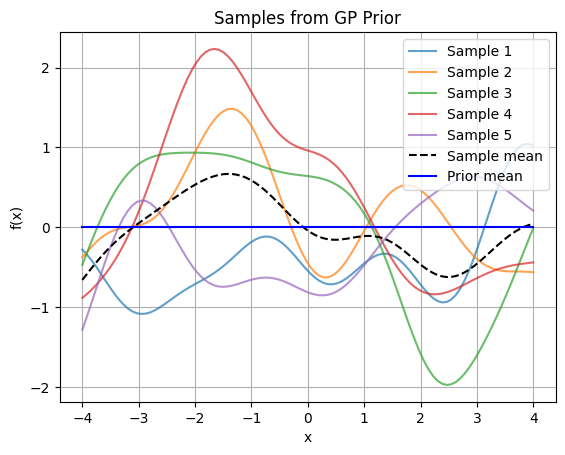

In [52]:
sample_count = 100 # input points to plot and predict
function_count = 5

# Domain: [-4,4], 1D
X = np.expand_dims(np.linspace(-4, 4, sample_count), 1) # shape: (40,1)

# Mean is zero for all x's
ys = np.random.multivariate_normal(
    mean=np.zeros(sample_count), cov=rbf_kernel(X,X), 
    size=function_count)
print(ys.shape) # (5, 100)
print(ys.size)

for i in range(function_count):
    plt.plot(X, ys[i], label=f"Sample {i+1}", alpha=0.7)

# Plot sample mean 
# np.mean(ys, axis=0) results in a 1D array of length 100
# The mean function of the GP prior is actually flat, 
# but the average of just 5 samples will not be perfectly flat - 
# it gets flatter as you sample more 
plt.plot(X, np.mean(ys, axis=0), color="black", linestyle="--", label="Sample mean")
plt.plot(X, np.zeros(sample_count), color='b', label="Prior mean")

plt.title("Samples from GP Prior")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.show()

# Regression with GP
Keep in mind our goal with GP regression is to predict the outputs $\mathbf{y}_2$ at some test inputs ($\mathbf{X}_2$) given training data (observed outputs $\mathbf{y}_1$ at training inputs $\mathbf{X}_1$). 

We do this by computing the posterior mean vector and posterior covariance matrix of $\mathbf{y}_2$. 

The joint distribution of training and test outputs is multivariate normal.
$$
\begin{bmatrix}
\mathbf{y}_1 \\
\mathbf{y}_2
\end{bmatrix}
\sim \mathcal{N} \left(
\begin{bmatrix}
\boldsymbol{\mu}_1 \\
\boldsymbol{\mu}_2
\end{bmatrix},
\begin{bmatrix}
\Sigma_{11} & \Sigma_{12} \\
\Sigma_{21} & \Sigma_{22}
\end{bmatrix}
\right)
$$


The conditional or posterior distribution is also normal.

$$
p(\mathbf{y}_2 \mid \mathbf{y}_1, X_1, X_2) = 
\mathcal{N}(\boldsymbol{\mu}_{2|1}, \Sigma_{2|1})
$$

The posterior mean vector:

$$
\boldsymbol{\mu}_{2|1} = \boldsymbol{\mu}_2 + \Sigma_{21} \Sigma_{11}^{-1}(\mathbf{y}_1 - \boldsymbol{\mu}_1)
$$

If we assume a zero mean prior ($\mu(x) = 0$), then:

$$
\boldsymbol{\mu}_{2|1} = \Sigma_{21} \Sigma_{11}^{-1} \mathbf{y}_1
$$

Here's the covariance matrix:
$$
\Sigma_{2|1} = \Sigma_{22} - \Sigma_{21}\Sigma_{11}^{-1}\Sigma_{12}
$$



Notes:
- $\mathbf{y}_1$: observed outputs at inputs $\mathbf{X}_1$
- $\mathbf{y}_2$: outputs we want to predict at inputs $\mathbf{X}_2$
- $\mathbf{\mu}_1$: vector of prior mean function values corresponding to the training inputs  $\mathbf{X}_1$
  - The term "prior mean" does not refer to the arithmetic mean in the traditional sense, but simply the function $\mu(x)$ evaluated at each point in a set.
  - This is a vector of length equal to the number of training points. 
- $\mathbf{\mu}_1$: vector of prior mean function values corresponding to the test inputs  $\mathbf{X}_2$
  - This is a vector of length equal to the number of test points. 
- $\mathbf{\mu}_{2|1}$: vector of posterior mean function values corresponding to the test outputs $\mathbf{y}_2$, given observed training data $\mathbf{X}_1, \mathbf{y}_1$
  - For each test input, the GP gives you a mean prediction and a variance. So this is a vector of length equal to the number of test points.
- $\mu(x)$: the prior mean function before seeing any data (here we assume $\mu(x) = 0$ for all $x$)
  - Formally, $$\mu(x) = \mathbb{E}[f(x)]$$
  - After observing training data, the posterior mean function is $$\mu_{2|1}(x) = \mathbb{E}[f(x) \mid \mathbf{X}_1, \mathbf{y}_1]$$ (in practice, we calculate the posterior mean function value at some test input $x_*$ using the formula above that's derived from properties of the MVN)
  - Having a zero mean simplifies our calculation 
  - In BO, for every update, we recalculate the mean and covariances for the posterior
  - We **don't** use past posterior means as input to future steps. Instead, each time we recompute the posterior mean from the **prior mean function** and the observed data $\mathbf{X}_1, \mathbf{y}_1$, i.e. from "scratch" (in practice, there are tricks to speed things up - Cholesky decomposition?).
  - Basically, GP inference is **stateless**.
- $k(x,x')$: the covariance function (kernel)
- $\Sigma_{11}$: covariance matrix between training points
  - The **training covariance matrix with noise** is defined as $$ \Sigma_{11} = k(\mathbf{X}_1, \mathbf{X}_1) + \sigma^2 I $$
  - Note that noise only changes the diagonal values of the kernel (the variance of each training observation). Noise is independently distributed.
  - Noisy observations are: $\mathbf{y}_1 = f(\mathbf{X}_1) + \epsilon$. Noise is typically modeled as $$\epsilon \sim \mathcal{N}(0, \sigma^2 I)$$
- $\Sigma_{22}$: covariance matrix between test points
  - We only include noise in training covariance to account for observation noise. We don't add noise to test covariance because we're trying to predict the laten/true function values (unless we're explicitly modeling noisy test outputs?). 
- $\Sigma_{12}$: covariance matrix between train and test points
- $\Sigma_{21} = {\Sigma_{12}}^\intercal$



In [53]:
def GP(X1, y1, X2, sigma=1.0, noise=0):
    """
    Compute the posterior mean and covariance of a Gaussian Process with RBF Kernel. 

    Parameters:
    - X1: (n,d) array of training inputs
    - y1: (n,1) array of training outputs
    - X2: (m,d) array of test inputs (where we want to predict)
    - sigma: RBF kernel parameter (length scale)
    - noise: for modeling noise (standard deviation, not variance) 

    Returns:
    - mu: (m,1) posterior mean or predicted values for X2
    - cov: (m,m) posterior covariance matrix for X2
    """
    # In case 1D array passed
    y1 = y1.reshape(-1, 1)
    
    # Kernel (covariance) matrices
    # Add noise on diagonal for K11
    K11 = rbf_kernel(X1, X1, sigma) + (noise**2) * np.eye(len(X1)) + 1e-8 * np.eye(len(X1)) # shape: (n,n)
    K22 = rbf_kernel(X2, X2, sigma)                                # shape: (m,m)
    K12 = rbf_kernel(X1, X2, sigma)                                # shape: (n,m)

    # Invert K11
    K11_inv = np.linalg.inv(K11)

    # Posterior mean
    mu = K12.T @ K11_inv @ y1 # # @ is matrix multiplication

    # Posterior covariance
    cov = K22 - K12.T @ K11_inv @ K12

    return mu, cov


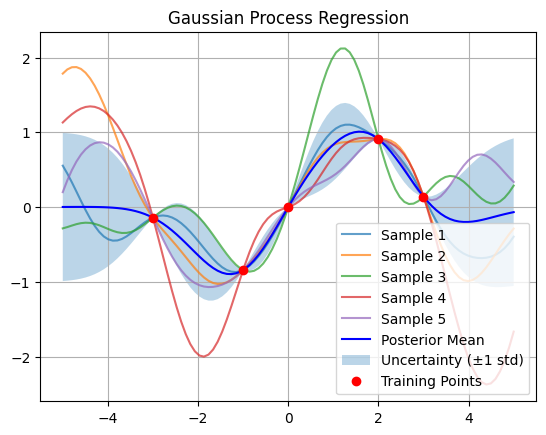

In [54]:
# Example with sine objective function (no observation noise)

# Training data
X_train = np.array([[-3], [-1], [0], [2], [3]])
y_train = np.sin(X_train) 

# Test inputs - grid of 100 points between -5 and 5
X_test = np.linspace(-5, 5, 100).reshape(-1, 1)

# Predict for X_test (no noise)
mu, cov = GP(X_train, y_train, X_test)

# Standard deviation
std = np.sqrt(np.diag(cov))

# Sample 5 functions from the posterior distribution (new mean and covariance)
ys = np.random.multivariate_normal(
    mean=mu.flatten(), cov=cov, 
    size=function_count)

# Plot sampled functions
for i in range(function_count):
    plt.plot(X_test, ys[i], label=f"Sample {i+1}", alpha=0.7)

# Plot posterior
plt.plot(X_test.flatten(), mu.flatten(), 'b', label="Posterior Mean")
plt.fill_between(
    X_test.flatten(),
    mu.flatten() - std.flatten(),
    mu.flatten() + std.flatten(),
    alpha=0.3,
    label="Uncertainty (±1 std)"
)
plt.plot(X_train, y_train, 'ro', label="Training Points")
plt.title("Gaussian Process Regression")
plt.legend()
plt.grid(True)
plt.show()

The uncertainty band in a Gaussian Process (GP) plot shows the range where the function value is most likely to lie.

While sampled functions from the GP can sometimes fall outside this band due to the randomness of sampling, this doesn't mean the true function values are likely to be that far away. This just reflects the probabilistic nature of the model.

Including ±2 or ±3 standard deviations in the uncertainty band covers a wider range of possible function values. Such bands are considered more "conservative", because they reflect a higher confidence that the true function lies within that range.

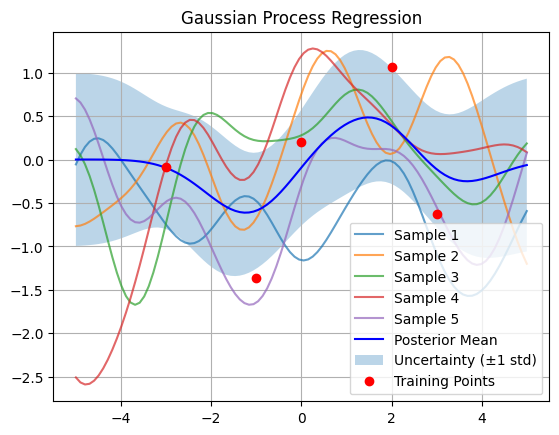

In [55]:
# Example with noisy observations

noise = 1 # standard deviation

# Training data
X_train = np.array([[-3], [-1], [0], [2], [3]])

# Objective function is NOISY
# np.random.randn(*x.shape) generates decimal value(s) from a normal distribution (mean 0, std 1)
# the resulting vector will have the same shape as x
# noise is a scaling factor
y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)

# Test inputs - grid of 100 points between -5 and 5
X_test = np.linspace(-5, 5, 100).reshape(-1, 1)

# Predict for X_test 
mu, cov = GP(X_train, y_train, X_test, noise=noise)

# Standard deviation
std = np.sqrt(np.diag(cov))

# Sample 5 functions from the posterior distribution (new mean and covariance)
ys = np.random.multivariate_normal(
    mean=mu.flatten(), cov=cov, 
    size=function_count)

# Plot sampled functions
for i in range(function_count):
    plt.plot(X_test, ys[i], label=f"Sample {i+1}", alpha=0.7)

# Plot posterior
plt.plot(X_test.flatten(), mu.flatten(), 'b', label="Posterior Mean")
plt.fill_between(
    X_test.flatten(),
    mu.flatten() - std.flatten(),
    mu.flatten() + std.flatten(),
    alpha=0.3,
    label="Uncertainty (±1 std)"
)
plt.plot(X_train, y_train, 'ro', label="Training Points")
plt.title("Gaussian Process Regression")
plt.legend()
plt.grid(True)
plt.show()

## Combining GP with Bayesian Optimization
In GP, we predict function values given training data. But where does that training data come from, and how should it be sampled? BO answers that question.

The loop:
1. Collect an initial set of observations (training data). 
2. Fit/update GP on training data - compute the posterior mean and covariance.
   - No internal states! You use the prior mean as the base each and every time. 
4. Use posterior to compute acquisition scores for a grid of test points.
5. Choose next point to observe.
6. Evaluate that point on the true function.
7. Augment dataset to include the new observed point.
8. Repeat.

**Notes:**
- The choice of acquisition function is secondary to the choice of surrogate model.

In [56]:
# This is a simple 1D function example
def objective(x, noise=0):
    # np.random.randn(*x.shape) generates decimal value(s) from a normal distribution (mean 0, std 1)
    # the resulting vector will have the same shape as x
    # noise is a scaling factor
    return np.sin(x) + noise * np.random.randn(*x.shape)

# Acquisition function: UCB
def acquisition_ucb(mu, std, beta=2.0):
    return mu + beta * std

def bayesian_opt(obj, bounds, init_points=5, iterations=10, beta=2.0, sigma=1.0, noise=0):
    """
    beta: UCB acquisition parameter
    sigma: RBF kernel parameter
    noise: standard deviation, not variance
    """
    # Initial data
    X_train = np.random.uniform(bounds[0], bounds[1], size=(init_points, 1))
    y_train = objective(X_train, noise)

    # Evaluation grid for plotting and acquisition
    X_grid = np.linspace(bounds[0], bounds[1], 1000).reshape(-1, 1)

    mu = None
    cov = None
    std = None
    for i in range(iterations):
        # Update surrogate, get predictions for X_grid
        mu, cov = GP(X_train, y_train, X_grid, sigma, noise)

        # Standard deviation for uncertainty 
        std = np.sqrt(np.diag(cov)).reshape(-1, 1)

        # Score each X_grid input
        scores = acquisition_ucb(mu, std)

        # Choose next point from X_grid
        next_x = X_grid[np.argmax(scores)]
        next_y = objective(next_x, noise)

        # Append to training data
        X_train = np.vstack((X_train, next_x.reshape(1, -1)))
        y_train = np.vstack((y_train, next_y.reshape(1, -1)))

    plt.plot(X_train, y_train, 'ro', label="Training Points")
    plt.plot(X_grid.flatten(), mu.flatten(), 'b', label="Posterior Mean")
    plt.fill_between(X_grid.flatten(),
        mu.flatten() - std.flatten(),
        mu.flatten() + std.flatten(),
        alpha=0.3,
        label="Uncertainty (±1 std)"
    )
    plt.title("Bayesian Optimization with Gaussian Process")
    plt.legend()
    plt.grid(True)
    plt.show()


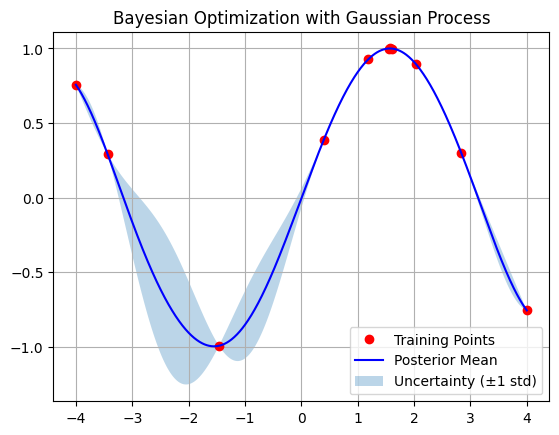

In [57]:
# Run BO
bayesian_opt(objective, bounds=[-4, 4], init_points=3, iterations=8)

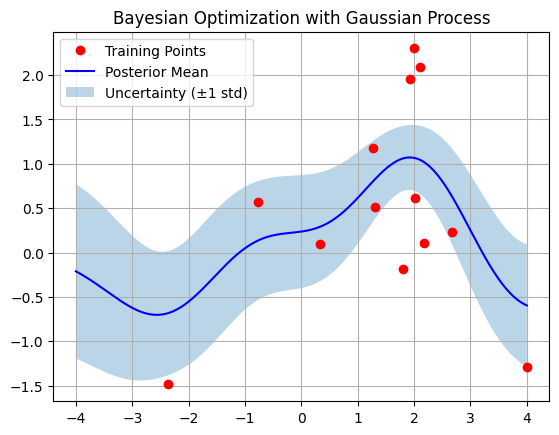

In [58]:
# BO with noisy observations 
bayesian_opt(objective, bounds=[-4, 4], init_points=3, noise=1)

# References
https://peterroelants.github.io/posts/gaussian-process-tutorial/